# Tweet Sentiment

In [ ]:
# Import the required tools
import re
import seaborn as sns
import nltk
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, plot_confusion_matrix
from sklearn.model_selection import cross_val_score
%matplotlib inline


In [ ]:
# Import the data
train = pd.read_csv("drive/Shared drives/Raj/Tweet Sentiement/train_2kmZucJ.csv")
test = pd.read_csv("drive/Shared drives/Raj/Tweet Sentiement/test_oJQbWVk.csv")

In [ ]:
train

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0,Finally a transparant silicon case ^^ Thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...
3,4,0,I'm wired I know I'm George I was made that wa...
4,5,1,What amazing service! Apple won't even talk to...
...,...,...,...
7915,7916,0,Live out loud #lol #liveoutloud #selfie #smile...
7916,7917,0,We would like to wish you an amazing day! Make...
7917,7918,0,Helping my lovely 90 year old neighbor with he...
7918,7919,0,Finally got my #smart #pocket #wifi stay conne...


In [ ]:
train["label"].value_counts()

0    5894
1    2026
Name: label, dtype: int64

In [ ]:
train_data = train.drop("id", axis=1)
train_data

,label,tweet
0,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,0,Finally a transparant silicon case ^^ Thanks t...
2,0,We love this! Would you go? #talk #makememorie...
3,0,I'm wired I know I'm George I was made that wa...
4,1,What amazing service! Apple won't even talk to...
...,...,...
7915,0,Live out loud #lol #liveoutloud #selfie #smile...
7916,0,We would like to wish you an amazing day! Make...
7917,0,Helping my lovely 90 year old neighbor with he...
7918,0,Finally got my #smart #pocket #wifi stay conne...


## Clean and preprocess the tweet

### Remove patterns

In [ ]:
def remove_pattern(input_txt, pattern):
  r = re.findall(pattern, input_txt)
  for i in r:
    input_txt = re.sub(i, "", input_txt)
  return input_txt

In [ ]:
# Remove twitter handlers
train["clean_tweet"] = np.vectorize(remove_pattern)(train["tweet"], "@[\w]*")
test["clean_tweet"] = np.vectorize(remove_pattern)(test["tweet"], "@[\w]*")

In [ ]:
# Removing special character, punctuations, etc.
train["clean_tweet"] = train["clean_tweet"].str.replace("[^a-zA-Z#]", " ")
test["clean_tweet"] = test["clean_tweet"].str.replace("[^a-zA-Z#]", " ")

In [ ]:
# Remove short words
train["clean_tweet"] = train["clean_tweet"].apply(lambda x: " ".join([w for w in x.split() if len(w) > 3]))
test["clean_tweet"] = test["clean_tweet"].apply(lambda x: " ".join([w for w in x.split() if len(w) > 3]))

In [ ]:
train.head()

,id,label,tweet,clean_tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...,#fingerprint #Pregnancy Test https MfQV #andro...
1,2,0,Finally a transparant silicon case ^^ Thanks t...,Finally transparant silicon case Thanks uncle ...
2,3,0,We love this! Would you go? #talk #makememorie...,love this Would #talk #makememories #unplug #r...
3,4,0,I'm wired I know I'm George I was made that wa...,wired know George made that #iphone #cute #dav...
4,5,1,What amazing service! Apple won't even talk to...,What amazing service Apple even talk about que...


In [ ]:
test.head()

,id,tweet,clean_tweet
0,7921,I hate the new #iphone upgrade. Won't let me d...,hate #iphone upgrade download apps #ugh #apple...
1,7922,currently shitting my fucking pants. #apple #i...,currently shitting fucking pants #apple #iMac ...
2,7923,"I'd like to puts some CD-ROMS on my iPad, is t...",like puts some ROMS iPad that possible wouldn ...
3,7924,My ipod is officially dead. I lost all my pict...,ipod officially dead lost pictures videos from...
4,7925,Been fighting iTunes all night! I only want th...,Been fighting iTunes night only want music paid


### Tokenize the tweet

In [ ]:
tokenize_tweet = train["clean_tweet"].apply(lambda x:x.split())
tokenize_tweet.head()

0    [#fingerprint, #Pregnancy, Test, https, MfQV, ...
1    [Finally, transparant, silicon, case, Thanks, ...
2    [love, this, Would, #talk, #makememories, #unp...
3    [wired, know, George, made, that, #iphone, #cu...
4    [What, amazing, service, Apple, even, talk, ab...
Name: clean_tweet, dtype: object

In [ ]:
test_tweet = test["clean_tweet"].apply(lambda x:x.split())
test_tweet.head()

0    [hate, #iphone, upgrade, download, apps, #ugh,...
1    [currently, shitting, fucking, pants, #apple, ...
2    [like, puts, some, ROMS, iPad, that, possible,...
3    [ipod, officially, dead, lost, pictures, video...
4    [Been, fighting, iTunes, night, only, want, mu...
Name: clean_tweet, dtype: object

### Stemming the tweet

In [ ]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenize_tweet = tokenize_tweet.apply(lambda x:[stemmer.stem(i) for i in x])
tokenize_tweet

0       [#fingerprint, #pregnanc, test, http, mfqv, #a...
1       [final, transpar, silicon, case, thank, uncl, ...
2       [love, thi, would, #talk, #makememori, #unplug...
3       [wire, know, georg, made, that, #iphon, #cute,...
4       [what, amaz, servic, appl, even, talk, about, ...
                              ...                        
7915    [live, loud, #lol, #liveoutloud, #selfi, #smil...
7916    [would, like, wish, amaz, make, everi, minut, ...
7917    [help, love, year, neighbor, with, ipad, thi, ...
7918    [final, #smart, #pocket, #wifi, stay, connect,...
7919    [appl, barcelona, #appl, #store, #bcn, #barcel...
Name: clean_tweet, Length: 7920, dtype: object

In [ ]:
test_tweet = test_tweet.apply(lambda x:[stemmer.stem(i) for i in x])
test_tweet

0       [hate, #iphon, upgrad, download, app, #ugh, #a...
1       [current, shit, fuck, pant, #appl, #imac, #cas...
2       [like, put, some, rom, ipad, that, possibl, wo...
3       [ipod, offici, dead, lost, pictur, video, from...
4       [been, fight, itun, night, onli, want, music, ...
                              ...                        
1948    [#samsunggalaxynot, explod, burn, year, thank,...
1949    [avail, hoodi, check, here, http, zetasuppli, ...
1950    [there, goe, crack, right, across, screen, cou...
1951             [said, #adob, time, well, includ, #appl]
1952    [final, thanx, father, #samsung, #galaxi, #gif...
Name: clean_tweet, Length: 1953, dtype: object

In [ ]:
for i in range(len(tokenize_tweet)):
  tokenize_tweet[i] = " ".join(tokenize_tweet[i])

train["clean_tweet"] = tokenize_tweet

In [ ]:
for i in range(len(test_tweet)):
  test_tweet[i] = " ".join(test_tweet[i])

test["clean_tweet"] = test_tweet

In [ ]:
train

,id,label,tweet,clean_tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...,#fingerprint #pregnanc test http mfqv #android...
1,2,0,Finally a transparant silicon case ^^ Thanks t...,final transpar silicon case thank uncl #yay #s...
2,3,0,We love this! Would you go? #talk #makememorie...,love thi would #talk #makememori #unplug #rela...
3,4,0,I'm wired I know I'm George I was made that wa...,wire know georg made that #iphon #cute #davent...
4,5,1,What amazing service! Apple won't even talk to...,what amaz servic appl even talk about question...
...,...,...,...,...
7915,7916,0,Live out loud #lol #liveoutloud #selfie #smile...,live loud #lol #liveoutloud #selfi #smile #son...
7916,7917,0,We would like to wish you an amazing day! Make...,would like wish amaz make everi minut count #t...
7917,7918,0,Helping my lovely 90 year old neighbor with he...,help love year neighbor with ipad thi morn jus...
7918,7919,0,Finally got my #smart #pocket #wifi stay conne...,final #smart #pocket #wifi stay connect anytim...


In [ ]:
test

,id,tweet,clean_tweet
0,7921,I hate the new #iphone upgrade. Won't let me d...,hate #iphon upgrad download app #ugh #appl suck
1,7922,currently shitting my fucking pants. #apple #i...,current shit fuck pant #appl #imac #cashmoney ...
2,7923,"I'd like to puts some CD-ROMS on my iPad, is t...",like put some rom ipad that possibl wouldn tha...
3,7924,My ipod is officially dead. I lost all my pict...,ipod offici dead lost pictur video from concer...
4,7925,Been fighting iTunes all night! I only want th...,been fight itun night onli want music paid
...,...,...,...
1948,9869,"#SamsungGalaxyNote7 Explodes, Burns 6-Year-Old...",#samsunggalaxynot explod burn year thank rush ...
1949,9870,Now Available - Hoodie. Check it out here - ht...,avail hoodi check here http zetasuppli product...
1950,9871,There goes a crack right across the screen. If...,there goe crack right across screen could actu...
1951,9872,@codeofinterest as i said #Adobe big time we m...,said #adob time well includ #appl


## Create WordCloud

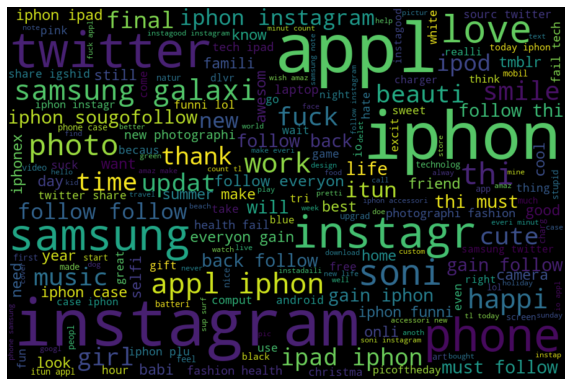

In [ ]:
# WordCloud for all the tweets
all_words = " ".join([text for text in train["clean_tweet"]])
from wordcloud import WordCloud
wordclouds = WordCloud(width=900, height=600, random_state=42, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 10))
plt.imshow(wordclouds, interpolation="bilinear")
plt.axis("off")
plt.show()

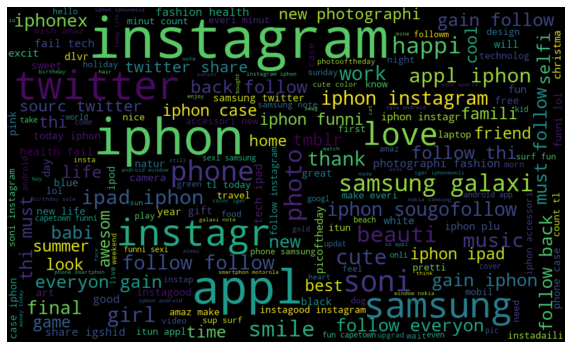

In [ ]:
# WordCloud for positive tweets
positive_words = " ".join([text for text in train["clean_tweet"][train["label"] == 0]])
wordcloud_0 = WordCloud(width=1000, height=600, random_state=42, max_font_size=100).generate(positive_words)

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud_0, interpolation="bilinear")
plt.axis("off")
plt.show()

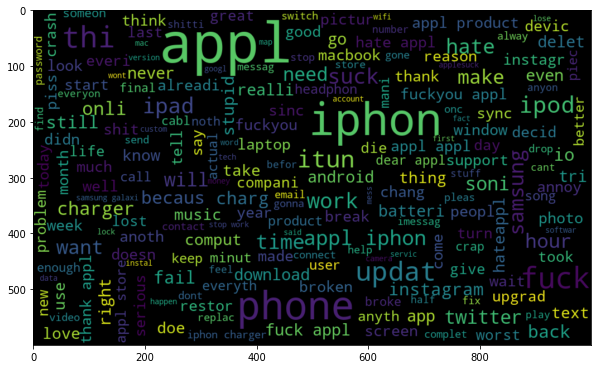

In [ ]:
# WordCloud for negative tweets
negative_words = " ".join([text for text in train["clean_tweet"][train["label"] == 1]])
wordcloud_1 = WordCloud(width=1000, height=600, random_state=42, max_font_size=100).generate(negative_words)

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud_1, interpolation="bilinear")
plt.axis="off"
plt.show()

In [ ]:
# Define a function for collecting hashtags
def hashtag(x):
  hashtags = []

  for i in x:
    ht = re.findall(r"#(\w+)", i)
    hashtags.append(ht)
  
  return hashtags

In [ ]:
hashtags_pos = hashtag(train["clean_tweet"][train["label"] == 0])
hashtags_neg = hashtag(train["clean_tweet"][train["label"] == 1])

ht_pos = sum(hashtags_pos, [])
ht_neg = sum(hashtags_neg, [])

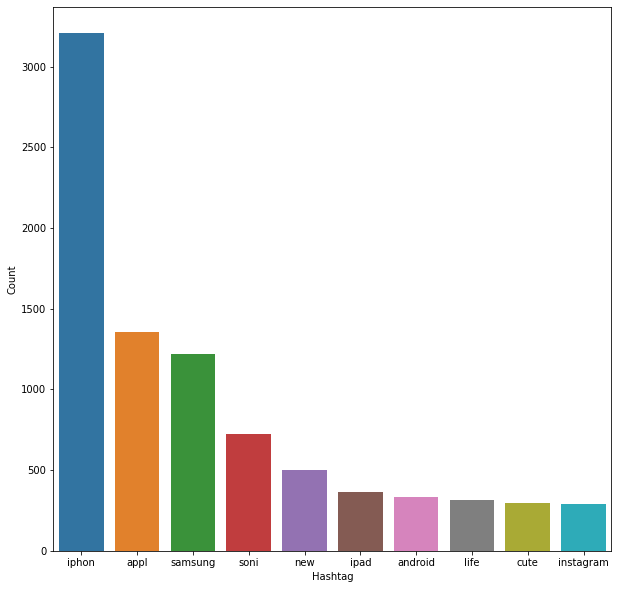

In [ ]:
a = nltk.FreqDist(ht_pos)
d = pd.DataFrame({
    "Hashtag":list(a.keys()),
    "Count":list(a.values())
})
d = d.nlargest(columns="Count", n=10)
plt.figure(figsize=(10, 10))
ax = sns.barplot(data=d, x="Hashtag", y="Count")
ax.set(ylabel="Count")
plt.show()

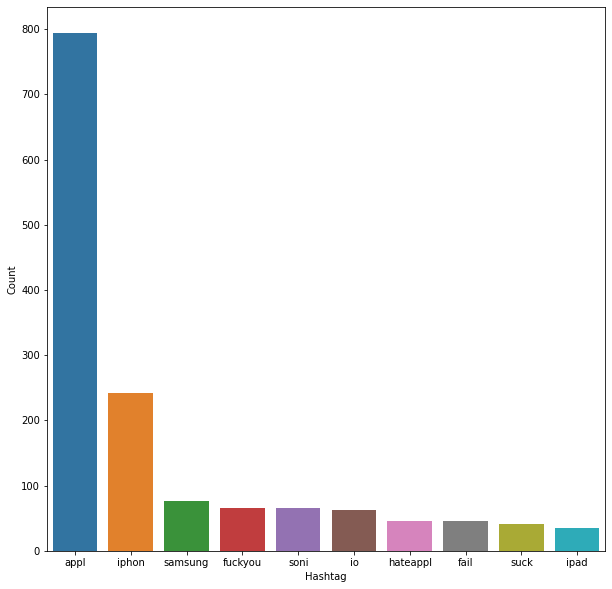

In [ ]:
b = nltk.FreqDist(ht_neg)
e = pd.DataFrame({
    "Hashtag":list(b.keys()),
    "Count":list(b.values())
})

e = e.nlargest(columns="Count", n=10)
plt.figure(figsize=(10, 10))
ax = sns.barplot(data=e, x="Hashtag", y="Count")
ax.set(ylabel="Count")
plt.show()

## Extracting Features

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vector = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words="english")
vector_tweet = vector.fit_transform(train["clean_tweet"])

In [ ]:
test_vector_tweet = vector.fit_transform(test["clean_tweet"])

## Modelling

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
x = vector_tweet
y = train["label"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [ ]:
x_train.shape, y_train.shape

((6336, 1000), (6336,))

In [ ]:
# Training the model with Random Forest
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
roc_auc_score(y_test, model_rf.predict(x_test))

0.8475357081678101

In [ ]:
cross_val_score(model_rf, x_test, y_test)

array([0.87697161, 0.87066246, 0.85804416, 0.85488959, 0.85759494])

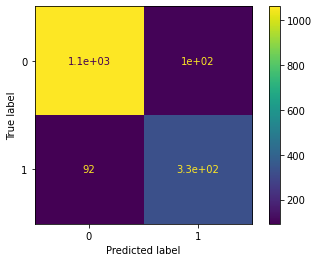

In [ ]:
plot_confusion_matrix(model_rf, x_test, y_test)

## Hyperparameter tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
params = {
    "n_estimators" : [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
    "max_features" : ['auto', 'sqrt'],
    "max_depth" : [int(x) for x in np.linspace(10, 110, num = 11)],
    "min_samples_split" : [2, 5, 10],
    "min_samples_leaf" : [1, 2, 4]
}

In [ ]:
rf_rcv = RandomizedSearchCV(model_rf,
                            param_distributions=params,
                            cv=5,
                            n_jobs=-1,
                            n_iter=20)
rf_rcv.fit(x_train, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
rf_rcv.best_params_

{'max_depth': 110,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 1800}

In [ ]:
model = RandomForestClassifier(max_depth= 110,
 max_features= 'sqrt',
 min_samples_leaf= 1,
 min_samples_split= 5,
 n_estimators= 1800)

model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=110, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=1800,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
cross_val_score(model, x_test, y_test)

array([0.87381703, 0.85804416, 0.85488959, 0.87381703, 0.86392405])

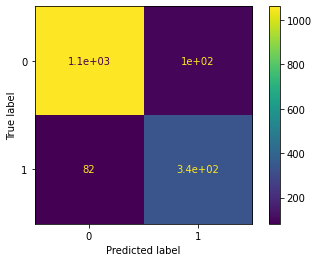

In [ ]:
plot_confusion_matrix(model, x_test, y_test)